In [77]:
import pandas as pd
import statsmodels as sm
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from datetime import datetime,date
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.seasonal
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from pandas import read_csv

on travaille sur le jeu de donnés ... 

In [78]:
df=pd.read_table("train.csv",sep = ',',header = 0)
df.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [79]:
#on travaille sur le 1er mois, on récupére que les 2 colonnes des dates et la consommation
data = df[['datetime','electricity_consumption']][552:1104]

#on transforme les données en série temporelle:
data= pd.Series(data['electricity_consumption'].values,index=pd.date_range('2013-08-01 00:00:00',periods=552,freq='h'))
data.head()

2013-08-01 00:00:00    228.0
2013-08-01 01:00:00    231.0
2013-08-01 02:00:00    216.0
2013-08-01 03:00:00    240.0
2013-08-01 04:00:00    228.0
Freq: H, dtype: float64

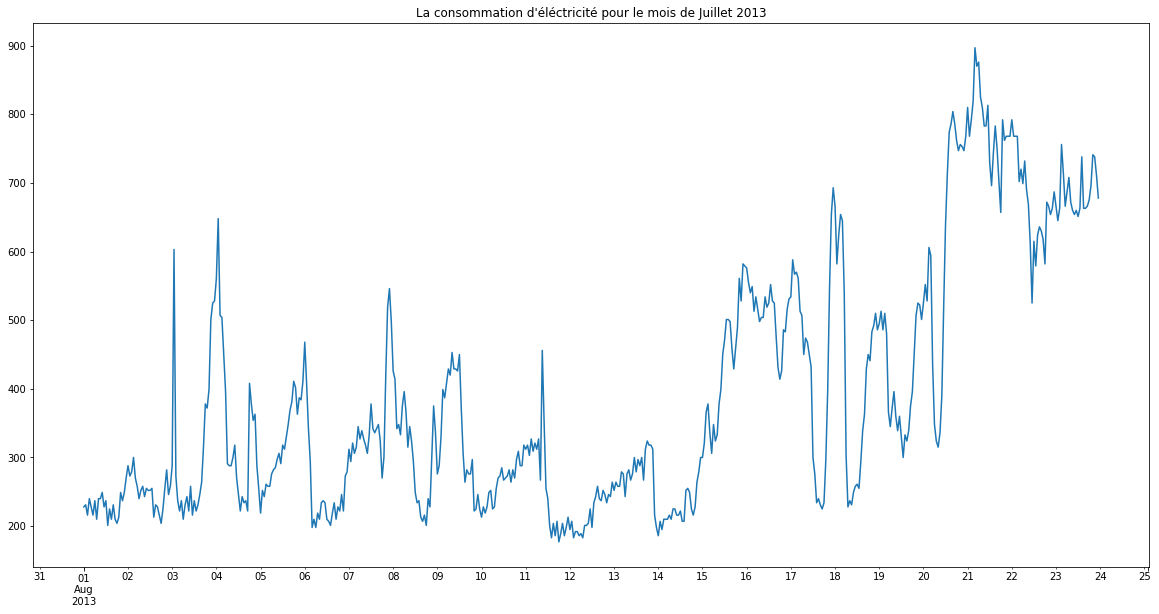

In [80]:
plt.figure(figsize=(20,10))
data.plot()
plt.title('La consommation d\'éléctricité pour le mois de Juillet 2013')
plt.savefig('data2.png')

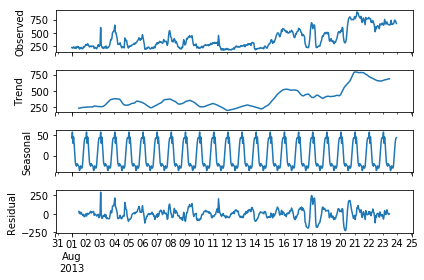

In [81]:
# visualiser la série et ces différentes composantes (en utilisant un modéle additive)
decomposition=statsmodels.tsa.seasonal.seasonal_decompose(data, model='additive')
decomposition.plot()

plt.show()


In [82]:
# Diviser les données en entrainement et test:
NumberOfElements = len(data)

# on utilise 70% pour l'entrainement et 30% pour le test 
TrainingSize = int(NumberOfElements * 0.7)
TrainingData = data[0:TrainingSize]
TestData = data[TrainingSize:]

In [83]:
# on vérifie la stationarité de la série, pour cela nous avons crées la fonctionne (stationnarite) qui prend 
# en paramétre la série temporelle et applique de le test de Dicky-Fuller expliqué dans le rapport

def stationnarite(timeseries):
    from statsmodels.tsa.stattools import adfuller
    print("Résultats du test de Dicky-Fuller:")
    df_test=adfuller(timeseries,autolag="AIC")
    df_output=pd.Series(df_test[0:4])

    print('p-value ',df_output[1:2].values)

In [84]:
# on applique le test de stationnarité sur la série:

stationnarite(data)

Résultats du test de Dicky-Fuller:
p-value  [0.04214792]


On remarque que le p-value est inférieur à 5%, ce qui montre que la série est stationnaire.
Donc, pour le choix de paramétres on prend d=0 (paramétre d'intégration).On passe au choix des autres paramétres.

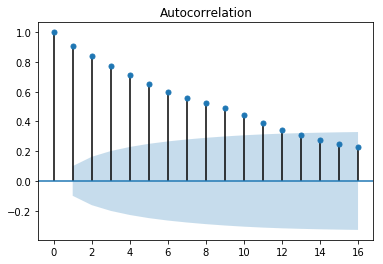

In [85]:
# on visualise le graphe d'autoccorélation, pour trouver la valeur max de q.
# lags est le nombre de décalages .
plot_acf(TrainingData, lags=16)
plt.show()

On ramarque que les décalages ne rentrent dans la zone de confidence qu'à partir du 14ème décalage.
On prend donc q=14.

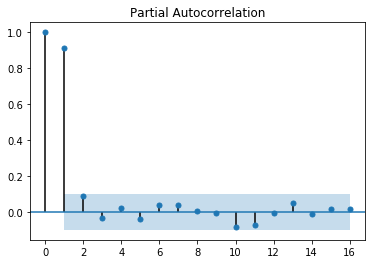

In [86]:
# on visualise le graphe d'autoccorélation partielle, pour trouver la valeur max de p.
plot_pacf(TrainingData, lags=16)
plt.show()

On ramarque que les décalages rentrent dans la zone de confidence à partir du 1èr décalage.
On prend donc q=1.

Comme on a cité dans le rapport, arima ne donne pas de bon résultat à long terme (il converge vers une valeur moyenne),
donc on a essayé de faire la prédiction de chaque 6h, puis aprés chaque 6h on mis à jour notre jeu de donnée.

In [119]:
#Créer 2 nouvelles tableau pour le stockage des données, ils seront utile dans le bloc suivant:
Actual = [x for x in TrainingData]
Predictions = list()
Base = [x for x in TrainingData]

# on essaye de prédire les 6h suivante, chaque 6h c-a-d: count%6 == 0, on mis à jour les données d'apprentissage:Base.
count =0
#définir l'ordre:

(p, d, q)=(1,0,3)

for timepoint in range(len(TestData)):
   
    if(count%6 == 0):
        Base=[x for x in Actual]

    ActualValue=TestData[timepoint]
   
    
    #prédire la valuer suivante:
    model = ARIMA(Base, order=(p, d, q))
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    pre=prediction[0]
    #######################################
    
    print('Réel=%f, Predit=%f' % (ActualValue, pre))
    Predictions.append(pre)
    Base.append(pre)
    Actual.append(ActualValue)
    count=count+1

Réel=567.000000, Predit=564.778748
Réel=570.000000, Predit=550.950668
Réel=561.000000, Predit=534.734373
Réel=513.000000, Predit=521.095547
Réel=507.000000, Predit=508.300837
Réel=450.000000, Predit=496.298106
Réel=474.000000, Predit=445.376566
Réel=468.000000, Predit=435.040905
Réel=450.000000, Predit=427.812624
Réel=432.000000, Predit=420.267467
Réel=300.000000, Predit=413.215196
Réel=276.000000, Predit=406.624074
Réel=234.000000, Predit=275.650681
Réel=240.000000, Predit=278.636328
Réel=231.000000, Predit=281.258323
Réel=225.000000, Predit=283.119993
Réel=234.000000, Predit=284.851148
Réel=297.000000, Predit=286.459860
Réel=396.000000, Predit=294.120894
Réel=546.000000, Predit=298.044258
Réel=654.000000, Predit=297.975219
Réel=693.000000, Predit=298.676088
Réel=666.000000, Predit=299.325937
Réel=582.000000, Predit=299.927604
Réel=624.000000, Predit=558.275248
Réel=654.000000, Predit=532.079054
Réel=645.000000, Predit=513.627347
Réel=540.000000, Predit=497.028136
Réel=303.000000, Pre

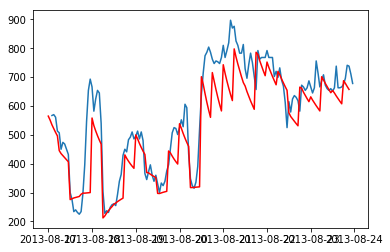

In [120]:
plt.plot(TestData)
np.ravel(Predictions)
Predictions= pd.Series(Predictions,index=pd.date_range('2013-08-17 00:00:00',periods=166,freq='h'))
plt.plot(Predictions, color='red')
plt.show()

In [ ]:
#erreur de la prédiction:
Error = mean_squared_error(TestData, Predictions)
Error

Pour savoir si le modéle est bien ajuster, on fait une étude du résidu qui doit suivre une loi normale.

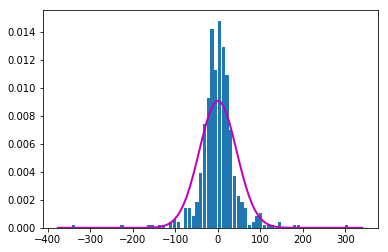

In [122]:
from scipy.stats import norm
residu=model_fit.resid
plt.hist(residu,bins='auto',density=True,rwidth=0.85,label='Residuals')#histogramme du residu.
moy , var =norm.fit(residu)
xmin , xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
p = norm.pdf(x,moy,var)
plt.plot(x,p,'m',linewidth=2)
plt.show()

Ce qu'on constate pour le résidu.

In [123]:
moy ,var

(0.2300581027858167, 43.88800773893862)

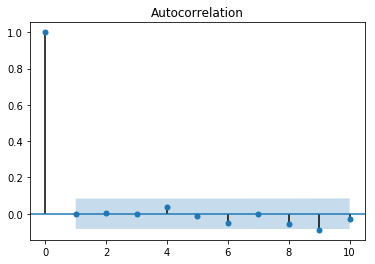

In [125]:
plot_acf(residu,lags=10)
plt.show()

On remarque qu'il n'y a pas d'autoccorélation sur le résidu, ce qui justifie qu'il ne reste plus d'information .. 

On travaille maintenant sur le 2 ème jeu de données où on va essayer de prédire un mois d'un seul coup

In [127]:
# on ouvre le jeu de données et on garde que les 2 colonnes qui contient la consommation et les dates.
df2= pd.read_csv('RU_Electricity_Market_PZ_dayahead_price_volume.csv')
df2=df2[['timestep','consumption_eur']]
df2.head()

,timestep,consumption_eur
0,2006-09-01 00:00,62341.0
1,2006-09-01 01:00,60625.0
2,2006-09-01 02:00,59685.0
3,2006-09-01 03:00,59500.0
4,2006-09-01 04:00,60617.0


In [173]:
# on récupére 70% des données pour l'apprentissage et on laisse 30% pour le test
train_size=30*24
train=df2[:train_size]
test=df2[train_size:2*train_size]

data2= pd.Series(train['consumption_eur'].values,index=pd.date_range('2006-09-01 00:00:00',periods=train_size,freq='h'))


test= pd.Series(test['consumption_eur'].values,index=pd.date_range('2006-10-01 00:00:00',periods=train_size,freq='h'))

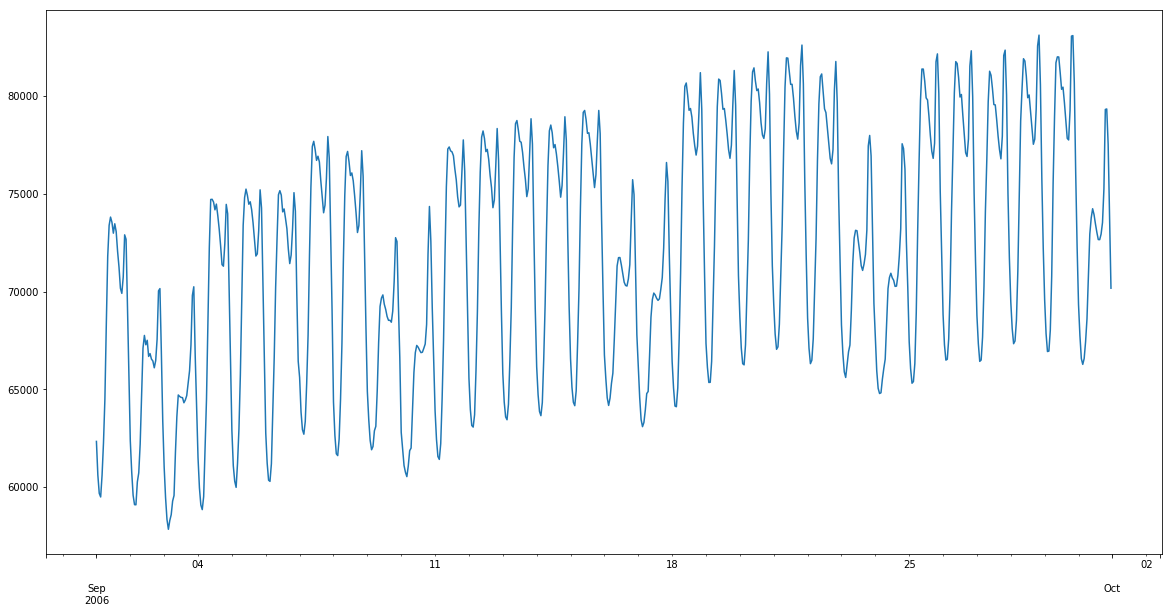

In [174]:
plt.figure(figsize=(20,10))
data2.plot()

In [175]:
# on applique le test de stationnarité sur la série:

stationnarite(data2)

Résultats du test de Dicky-Fuller:
p-value  [0.61727659]


In [176]:
# on différencie la série pour la rendre stationnaire
data_diff=data2.diff().dropna()

In [177]:
# on applique à nouveau le test de stationnarité
stationnarite(data_diff)

Résultats du test de Dicky-Fuller:
p-value  [6.02396079e-29]


Le p-value est trés faible, donc la série est stationnaire.
Alors une différenciation d'ordre 1 est suffisante pour rendre la série stationnaire (d=1)

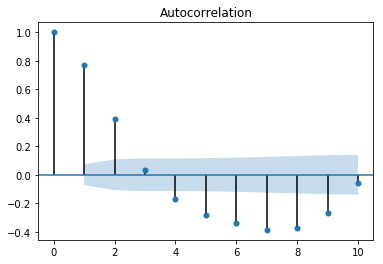

In [178]:
# on visualise le graphe d'autoccorélation, pour trouver la valeur max de q.
# lags est le nombre de décalages .
plot_acf(data_diff, lags=10)
plt.show()

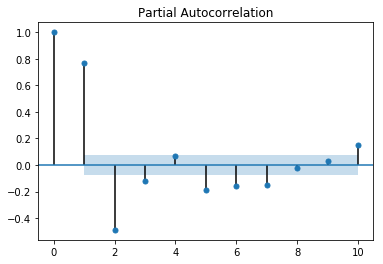

In [179]:
# on visualise le graphe d'autoccorélation partielle, pour trouver la valeur max de p.
plot_pacf(data_diff, lags=10)
plt.show()

ou bien on peut procéder par une grille de recherche pour trouver les meilleurs valeurs des paramétres qui donne l'erreur la plus petite possible.

In [190]:
# evaluer ARIMA(p,d,q)

def evaluate_arima_model(X, arima_order):

    # preparer les donnees

    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]


    # Appliquer le modele

    predictions = list()    
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)#appliquer arima manuellement.
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calcule l erreur:

    
    error = mean_squared_error(test, predictions)
    return error



# Trouver les hyper-parametres

# evaluer combinason de: p, d , q valueurs pour un model ARIMA


def evaluate_models(dataset, p_values, d_values, q_values):

    dataset = dataset.astype('float32')

    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:

                order = (p,d,q) #les 3 boucles génére toutes les combinaisons possibles.

                try:

                    mse = evaluate_arima_model(dataset, order)

                    if mse < best_score:

                        best_score, best_cfg = mse, order

                        print('ARIMA%s MSE=%.3f' % (order,mse))

                except:

                    continue

    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    
    return order


In [ ]:
#essayer la grille:
import warnings
p_values = [1, 2]
d_values = [0,1]
q_values = [2,4,6,8]
warnings.filterwarnings("ignore")
ordre=()
ordre = evaluate_models(data2.values, p_values, d_values, q_values)

ARIMA(1, 0, 2) MSE=1547325.893
ARIMA(1, 0, 4) MSE=1377236.517
ARIMA(1, 0, 6) MSE=1367990.610


In [180]:
model=ARIMA(data2, order=ordre) #on peut procéder par une grille de recherche

In [181]:
result=model.fit()

In [183]:
fcast=result.predict(start='2006-10-01 00:00',end='2006-10-30 23:00')


In [187]:
data2.tail(1)

2006-09-30 23:00:00    70177.0
Freq: H, dtype: float64

In [188]:
#on élimine la différenciation appliqué par ARIMA sur la série:
data2int=np.cumsum(fcast)+70177.0

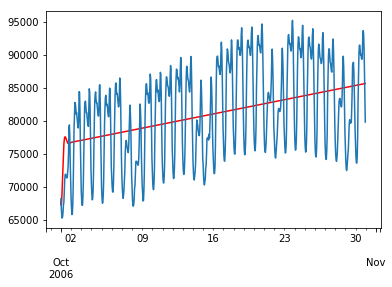

In [189]:
data2int.plot(color='r')
test.plot()

Apparement le modéle ne donne pas un bon résultat, ce qui est compatible avec ce qu'on a cité dans le rapport. En fait ARIMA ne donne pas une bonne prédiction à long terme.